<a href="https://colab.research.google.com/github/jwhogg/word2vec-from-scratch/blob/main/word2vec_from_scatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('gutenberg')
# nltk.corpus.gutenberg.fileids()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [ ]:
all_texts = ""

for fileid in nltk.corpus.gutenberg.fileids():
    # Load the text of the current file and concatenate it
    all_texts += nltk.corpus.gutenberg.raw(fileid)

In [ ]:
all_texts[0:1000]

"[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.\n\nShe was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.  Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.\n\nSixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.  Between _them_ it was more the intimacy\nof sisters.  Even before Miss Taylor had ceased to hold the nominal\noffice of 

In [ ]:
import re
pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
tokenised_corpus = pattern.findall(all_texts.lower())

In [ ]:
#Create token->id mapping and id->token mapping as these will come on handy later on:
#remember a token is basically a word

vocab = set(tokenised_corpus)
vocab = sorted(vocab)

token_to_id = {}
id_to_token = {}

for id, token in enumerate(vocab):
  token_to_id[token] = id
  id_to_token[id] = token

In [ ]:
#Create a bag of words:

bag_of_words = {word: 1 for word, id in token_to_id.items()}  #.items() is a list of (key, value) pairs

for word in tokenised_corpus:
    bag_of_words[word] = bag_of_words[word] + 1

### One-Hot Encoding:
- each word is represented as a sparse vector, with length of the Vocab
- a 1 would be in the position of the word's ID

We can create all the encodings for each word by using an identity matrix, where the encoding for a word corresponds to the id'th row

In [ ]:
import numpy as np
vocab_size = len(vocab)
encodings = np.identity(vocab_size)

### Generate training pairs
- we need a list of all the Y values (target) (first item of each pair), and a list of all the X (context) values- second item of each pair

- using the context window, generate pairs (X,Y), where for a target word Y, we get our context words Xs from +- size of context window

In [ ]:
from itertools import chain
from tqdm import tqdm

context_size = 5
corpus_size = len(tokenised_corpus)
vocab_size = len(vocab)

# training_data = []

#  for every word (Y) in the corpus, generate pairs from words (X) within the
#  range of the context window

total_iterations = 0

for y in range(corpus_size):
    context_range = chain(range(max(0, y - context_size), y), \
                          range(y + 1, min(y + context_size + 1, corpus_size)))  # exclude y itself

    total_iterations += len(list(context_range))

# training_data = np.empty((total_iterations,2,len(vocab)),dtype=np.int8)
training_data = np.memmap('training_data.dat', dtype=np.int8, mode='w+', \
                          shape=(total_iterations,2,vocab_size))


#precalculate encoding word ids for each index in the corpus
index_to_ids = np.array([token_to_id[token] for token in tokenised_corpus])

# Compute the context_range indices using broadcasting
# context_range = [np.concatenate((np.arange(max(0, y-context_size), y), \
#                                            np.arange(y+1, min(y+context_size+1, corpus_size)))) \
#                           for y in range(corpus_size)]

# np.arrange() in this case will produce 0,1,2... -> corpus_size
# np.repeat() will use the 2nd arg to repeat elements in the 1st args list based on index
# eg: the ith index in the 2nd arg list gives how many times to repeat the element
#   in the ith index of 1st arg's list
# TLDR: this code will generate the relevant corpus indexes for training
# y_indices = np.repeat(np.arange(corpus_size), [len(indices) for indices in context_range])
# x_indices = np.concatenate(context_range)

# Assign the values directly to the training_data array using advanced indexing
# training_data[np.arange(total_iterations), 0, index_to_ids[y_indices] - 1] \
#                                     = encodings[index_to_ids[y_indices] - 1]

# training_data[np.arange(total_iterations), 1, index_to_ids[x_indices] - 1] \
#                                     = encodings[index_to_ids[x_indices] - 1]


# context_ranges = np.array([np.concatenate([np.arange(max(0,y-context_size),y), \
#                       np.arange(y, min(y+context_size, corpus_size))]) for y in range(corpus_size)])
context_ranges = []
for y in range(corpus_size):
  context_ranges.append(np.concatenate([np.arange(max(0,y-context_size),y), \
                            np.arange(y, min(y+context_size, corpus_size))]))


for y in tqdm(range(corpus_size)): #  tqdm adds progress bar
  #  use max and min so we dont go bellow 0 or beyond vocab size in terms of word pointers
  # context_range = np.concatenate([np.arange(max(0,y-context_size),y), \
  #                       np.arange(y, min(y+context_size, corpus_size))])
  context_range = context_ranges[y]

  for x in context_range:
    if y==x: continue
    #  need to convert corpus index into word id
    # y_id, x_id = token_to_id[tokenised_corpus[y]], \
    #               token_to_id[tokenised_corpus[x]]
    y_id, x_id = index_to_ids[y], index_to_ids[x]


    # training_data[y] = np.stack((encodings[y_id-1], encodings[x_id-1]), axis=0)
    training_data[y, 0, :] = encodings[y_id-1]
    training_data[y, 1, :] = encodings[x_id-1]

training_data.flush()

# training_data = np.array(training_data) # this takes too much memory

 46%|████▌     | 972626/2118899 [20:17<21:25, 891.84it/s] 

In [ ]:
index_to_ids = np.array([token_to_id[token] for token in tokenised_corpus])

training_data[np.arange(total_iterations), 0, index_to_ids[y_indices] - 1]

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
np.repeat([1,2,3], [1,2,3])

array([1, 2, 2, 3, 3, 3])

In [ ]:
[len(indices) for indices in context_range]

[5,
 6,
 7,
 8,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,


## Define Model
\begin{align*}
A_1 &= XW_1 \\
A_2 &= A_1W_2 \\
Z &= \text{softmax}(A_2)
\end{align*}

* X (input) will be the OHE vector of a context word, thus of shape (|V|,1)
* W1 will be shape: (|V|,embedding_size) as it transforms input to hidden layer
* W2 will be shape: (embedding_size,|V|) as it transforms hidden -> output
* Z (output) will be the OHE vector of the prediction word, thus shape (|V|,1)

#### Backpropagation:

Differntiated Cross Entropy loss:
\begin{align*}
Z - y
\end{align*}



In [ ]:
class Model():
  def __init__(self, embedding_size, vocab_size, lr): #  embed size -> hidden size
    self.w1 = np.random.randn(vocab_size, embedding_size)
    self.w2 = np.random.randn(embedding_size, vocab_size)
    self.lr = lr

  def forward(self, x):
    a1 = np.dot(self.w1.T,x)
    a2 = np.dot(self.w2.T,a1)
    z = self.softmax(a2)
    return z, a2, a1 #  prediction, output layer, hidden layer

  def backprop(self, e, a1, x): #  takes e (error), a1 (hidden), x (input)
    # self.da2 = z - y
    #  to calculate the gradient of the loss w.r.t W2,
    #  do the outer prod of hidden layer activs & error
    dw2 = np.outer(a1,e)
    # self.da1 = self.da2 @ self.w2.T
    hidden_error = np.dot(self.w2,e.T)
    # dw1 = (x.reshape(-1,1)).dot(self.da1.reshape(-1,1).T)
    dw1 = np.outer(x,hidden_error)

    self.w1 -= self.lr * self.dw1
    self.w2 -= self.lr * self.dw2

    # CEL = self.cross_entropy(z,y)
    # return CEL

  def softmax(self, x): #  numerically stable softmax
      return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

  def cross_entropy(self, z, y):
    return - np.sum(np.log(z) * y)

In [ ]:
model = Model(400, len(vocab),lr=0.01)

In [ ]:
test = np.zeros(len(vocab))
test[2] = 1
test.shape
pp = model.forward(test)
pp.shape

(44449,)

In [ ]:
training_data[0]

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]

In [ ]:
numpy_array = np.memmap('training_data.npy', dtype='float32', mode='w+', shape=(len(training_data),2,len(vocab)))

# Copy the data from the Python list to the NumPy array
numpy_array[:] = training_data
del training_data

KeyboardInterrupt: 

In [ ]:
len(training_data)

19070066

In [ ]:
import pickle

#Training

alpha = 0.001

#dev training sets that dont take as long:
dev_set_percentage = 0.002
num_examples = len(training_data)

# Calculate the number of examples to include in the dev set
num_dev_examples = int(num_examples * dev_set_percentage)

# Shuffle the indices of the training set
shuffled_indices = np.random.permutation(num_examples)

# Select the first num_dev_examples indices to create the dev set
dev_indices = shuffled_indices[:num_dev_examples]

# Use the selected indices to create the dev set
# X_dev = [X[i] for i in dev_indices]
# Y_dev = [Y[i] for i in dev_indices]
dev_training_data = [training_data[i] for i in dev_indices]

#  save to disk and delete from memory to free up memory
# with open('training_data.pkl', 'wb') as f:
#   pickle.dump(training_data,f)
del training_data #delete this line

#convert to numpy array for speed
# dev_training_data = np.array(dev_training_data)

history = []

# for i in tqdm(range(0,len(X_dev)-1)):
#   x = X_dev[i] #  input
#   y = Y_dev[i] #  target

#   z = model.forward(x)
#   error = model.backprop(z,y,x,alpha)
#   error_history[i] = error

# for Y, X in tqdm(training_data):


In [ ]:
dev_training_data = np.array(dev_training_data)

In [ ]:
#  tqdm creates porgress bar
for i, (Y, X) in tqdm(enumerate(dev_training_data), total=len(dev_training_data)):
  y_pred, a2, a1 = model.forward(X)

  0%|          | 415/19070066 [00:12<165:55:18, 31.93it/s]


KeyboardInterrupt: 

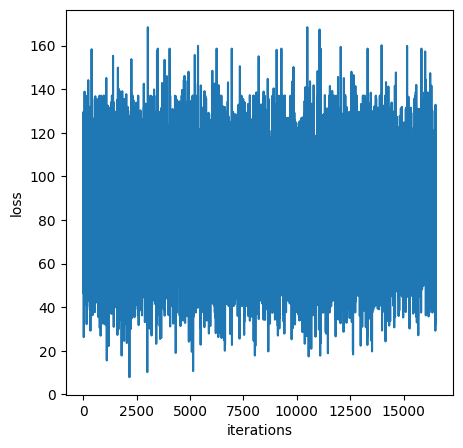

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(list(error_history.keys()), list(error_history.values()))
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [ ]:
((error_history.values()))

dict_values([None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [ ]:
(x.reshape(-1,1)).dot(model.da1.reshape(-1,1).T)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x @

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 400 is different from 44449)